In [1]:
import os
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import widgets

### Load and merge data files

In [2]:
## Read local data file and merge
data_dir = "data"
file1 = 'data_ld_vregistration_by_state_by_year.csv'
file2 = 'data_ev_credits_fees_by_state_by_year_v4.csv'
file3 = 'data_political_leaning.csv'
file4 = 'data_ev_charging_stations.csv'

# Registrations: Light-Duty Vehicle Registration Counts by State and Fuel Type
df_registrations = pd.read_csv(os.path.join(data_dir, file1))
# Incentives: State Electric Vehicle Tax Credits and Registration Fees, in US Dollars
df_incentives = pd.read_csv(os.path.join(data_dir, file2))
# Political Leaning
df_political_leaning = pd.read_csv(os.path.join(data_dir, file3))
# Charging Stations
df_charging_stations = pd.read_csv(os.path.join(data_dir, file4))

# Merge dataframes on 'State' and 'Year'
data_frames = [df_incentives, df_political_leaning, df_registrations, df_charging_stations]
df = reduce(lambda  left, right: pd.merge(left, right, on=['State', 'Year']), data_frames)

# Drop irrelevant columns
cols_to_keep = ['State', 'Year', 'Incentive ($)', 'Additional Registration Fee ($/year)', 
                'dem_margin', 'num_stations', 'num_charging_outlets', 'Electric (EV)']
df = df[cols_to_keep]

In [3]:
df.head()

,State,Year,Incentive ($),Additional Registration Fee ($/year),dem_margin,num_stations,num_charging_outlets,Electric (EV)
0,Alabama,2016,0.0,200.0,-25.5,113,227,500
1,Alaska,2016,0.0,0.0,-10.1,3,5,200
2,Arizona,2016,0.0,0.0,0.3,424,988,4700
3,Arkansas,2016,0.0,200.0,-27.6,63,89,200
4,California,2016,2000.0,108.0,29.2,4184,13655,141500


In [4]:
df.shape

(350, 8)

### Preprocessing and feature engineering

In [5]:
## Add column with Electric Vehicle (EV) Sales Market Share 
# (percent of EVs sold of total light vehicles sold within each state, each year)

## Overall light-duty vehicle sales by state and year:
# By state, in 2022
# read table from 'https://www.factorywarrantylist.com/car-sales-by-state.html'
url_overall_by_state_2022 = 'https://www.factorywarrantylist.com/car-sales-by-state.html'
df_overall_by_state_2022 = pd.read_html(url_overall_by_state_2022)[2]
# clean up table formatting
df_overall_by_state_2022 = df_overall_by_state_2022.drop(df_overall_by_state_2022.index[[0,1,52]])
df_overall_by_state_2022['Car Sales'] = df_overall_by_state_2022['Car Sales'].astype(int)

# By year, across the US 
# read table downloaded from https://www.energy.gov/eere/vehicles/articles/fotw-1276-february-6-2023-us-new-light-duty-vehicle-sales-totaled-138
file3 = 'FOTW_1276_web.xlsx'
filepath3 = os.path.join(data_dir, file3)
df_overall_US_by_year = pd.read_excel(filepath3, header = 4)
# clean up table formatting
df_overall_US_by_year.drop(df_overall_US_by_year.tail(4).index, inplace = True)

# Estimate overall light-duty vehicle sales by state and year
overall_2022 = df_overall_US_by_year['Vehicle Sales (Millions)'][df_overall_US_by_year['Calendar Year'] == 2022].values[0]
overall_by_state_and_year = pd.DataFrame()
for year in range(2016,2022+1):
    overall_this_year = df_overall_US_by_year['Vehicle Sales (Millions)'][df_overall_US_by_year['Calendar Year'] == year].values[0]
    df_this_year = pd.DataFrame()
    df_this_year['State'] = df_overall_by_state_2022['State']
    df_this_year['Car Sales'] = df_overall_by_state_2022['Car Sales'] * overall_this_year / overall_2022
    df_this_year['Year'] = [year]*df_this_year.shape[0]
    # print(df_this_year.head())
    overall_by_state_and_year = pd.concat([overall_by_state_and_year, df_this_year])

overall_by_state_and_year.to_csv(os.path.join(data_dir, 'Overall vehicle sales by state and year.csv'), index = False)

# Merge data frames
df = pd.merge(df, overall_by_state_and_year, on=['State', 'Year'])

# Add column with EV Sales Market Share
new_col = df.set_index(['State', 'Year']).groupby(level=0)['Electric (EV)'].diff()    # EV sales within each state, each year
new_col = new_col.reset_index()
new_col.iloc[:, 2] = new_col.iloc[:, 2] * 100 / df['Car Sales']
df['EV Sales Market Share'] = new_col.iloc[:, 2]

# Add column with number of EV charging stations normalized to the number of car sales in each state
df['norm_num_stations'] = df['num_stations'] / df['Car Sales']

In [6]:
# Save df
data_dir = "data"
save_df_file = 'data_EVs.csv'
save_df_filepath = os.path.join(data_dir, save_df_file)

df.to_csv(save_df_filepath, index = False)
# df = pd.read_csv(save_df_filepath)

In [7]:
df.head()

,State,Year,Incentive ($),Additional Registration Fee ($/year),dem_margin,num_stations,num_charging_outlets,Electric (EV),Car Sales,EV Sales Market Share,norm_num_stations
0,Alabama,2016,0.0,200.0,-25.5,113,227,500,2.245712e+05,NaN,0.000503
1,Alaska,2016,0.0,0.0,-10.1,3,5,200,3.367180e+04,NaN,0.000089
2,Arizona,2016,0.0,0.0,0.3,424,988,4700,4.145936e+05,NaN,0.001023
3,Arkansas,2016,0.0,200.0,-27.6,63,89,200,1.215532e+05,NaN,0.000518
4,California,2016,2000.0,108.0,29.2,4184,13655,141500,2.104669e+06,NaN,0.001988


### Plotting the data

Text(0, 0.5, 'Electric vehicles (EV)')

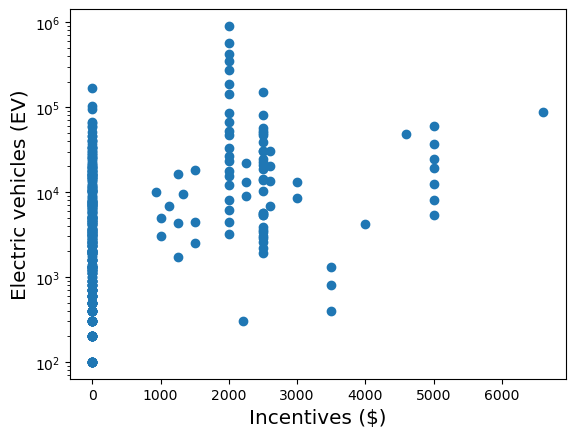

In [8]:
# Target y: 'Electric (EV)'
fig, ax = plt.subplots(1,1)
ax.scatter(df['Incentive ($)'], df['Electric (EV)'])
ax.set(yscale='log')
ax.set_xlabel('Incentives ($)', fontsize='x-large')
ax.set_ylabel('Electric vehicles (EV)', fontsize='x-large')

Text(0, 0.5, 'Electric vehicles (EV)')

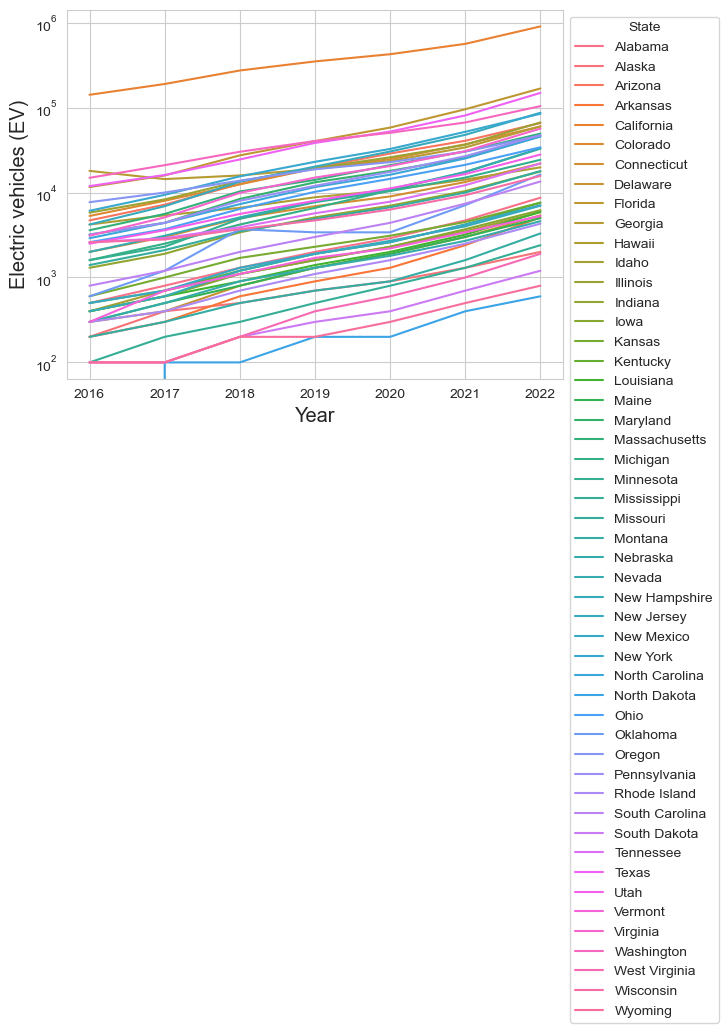

In [9]:
import seaborn as sns
sns.set_style("whitegrid")
ax = sns.lineplot(data=df, x='Year', y='Electric (EV)', hue='State')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(yscale='log')
ax.set_xlabel('Year', fontsize='x-large')
ax.set_ylabel('Electric vehicles (EV)', fontsize='x-large')

Text(0, 0.5, 'EV Sales Market Share')

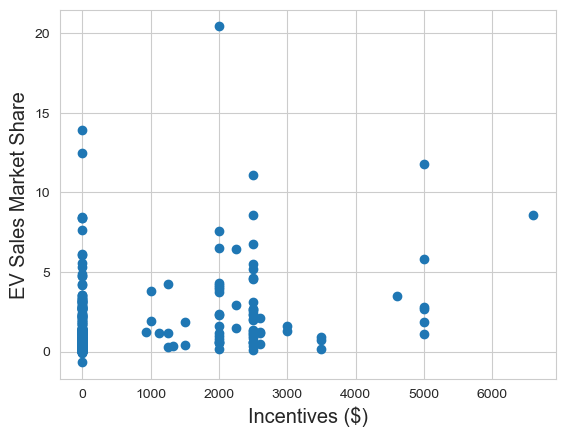

In [10]:
# Target y: 'EV Sales Market Share'
fig, ax = plt.subplots(1,1)
ax.scatter(df['Incentive ($)'], df['EV Sales Market Share'])
# ax.set(yscale='log')
ax.set_xlabel('Incentives ($)', fontsize='x-large')
ax.set_ylabel('EV Sales Market Share', fontsize='x-large')

Text(0, 0.5, 'EV Sales Market Share')

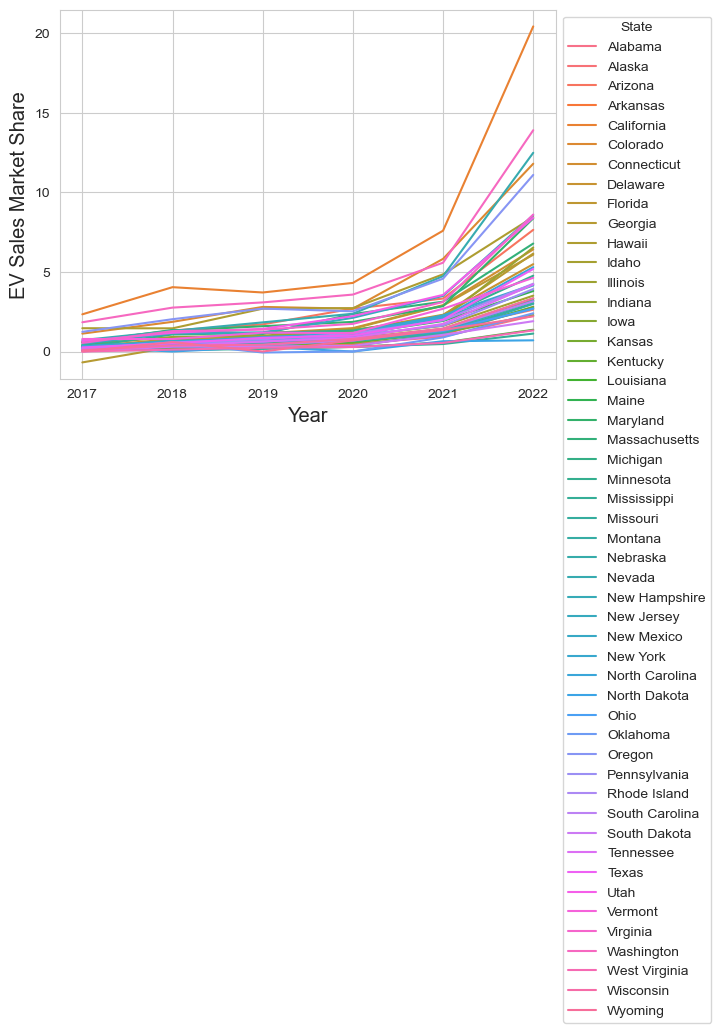

In [11]:
import seaborn as sns
sns.set_style("whitegrid")
ax = sns.lineplot(data=df, x='Year', y= 'EV Sales Market Share', hue='State')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# ax.set(yscale='log')
ax.set_xlabel('Year', fontsize='x-large')
ax.set_ylabel('EV Sales Market Share', fontsize='x-large')

In [21]:
all_features =['State', 'Year', 'Incentive ($)', 'Additional Registration Fee ($/year)', 'dem_margin', 'num_stations', 'num_charging_outlets', 'norm_num_stations']

def ev_plot(X, y):
    def plotter(column):
        valid_rows = X[column].notna()
        plt.plot(X.loc[valid_rows, column], y[valid_rows], 'o', color='b')
        plt.xlabel(column)
        plt.ylabel('EV Sales Market Share')
    return plotter

dropdown_values = {f'{k}': k for k in sorted(df[all_features].columns)}
widgets.interact(ev_plot(df[all_features], df['EV Sales Market Share']), column=dropdown_values)

### ML Models

In [12]:
## Setup X (feature matrix) and y (target)
df = df.dropna(subset=['EV Sales Market Share'])
all_features =['State', 'Year', 'Incentive ($)', 'Additional Registration Fee ($/year)', 'dem_margin', 'num_stations', 'num_charging_outlets', 'norm_num_stations']
features = ['Incentive ($)', 'Additional Registration Fee ($/year)', 'dem_margin', 'norm_num_stations']

X = df[all_features]    # features
y = df['EV Sales Market Share']    # target

#### Ridge Regression

In [13]:
print(f'Features: {features}')

Features: ['Incentive ($)', 'Additional Registration Fee ($/year)', 'dem_margin', 'norm_num_stations']


In [15]:
## Ridge regression hyperparameter tuning using GridSearchCV cross-validation
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, PolynomialFeatures

X_random_order, y_random_order = shuffle(X, y, random_state=42)

# Create column transformer 
selector = ColumnTransformer([
    ('numeric', 'passthrough', features)
])

params_Ridge = {'alpha': np.logspace(-3, 3, 20)}
# params_Ridge = {'alpha': np.logspace(-3, 3, 20), "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

ev_model_ridgeCV= Pipeline([
    ('features', selector),
    ('scaler', StandardScaler()),    # MinMaxScaler((-1,1))
    ('estimator', GridSearchCV(
    Ridge(),
    param_grid = params_Ridge, 
    cv=5,
    n_jobs=-1,
    verbose = 1
    )) 
])

ev_model_ridgeCV.fit(X_random_order, y_random_order)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Incentive ($)',
                                                   'Additional Registration '
                                                   'Fee ($/year)',
                                                   'dem_margin',
                                                   'norm_num_stations'])])),
                ('scaler', StandardScaler()),
                ('estimator',
                 GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
                              param_grid={'alpha': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])},
                              verbose=1))])

In [16]:
# Best model hyperparameters
print("The best hyperparameter value: ", ev_model_ridgeCV[2].best_params_)
print(f"R^2 score: {ev_model_ridgeCV.score(X_random_order, y_random_order) :.3f}")


The best hyperparameter value:  {'alpha': 54.555947811685144}
R^2 score: 0.490


In [17]:
# Ridge Regression with Standard Scaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create column transformer 
selector = ColumnTransformer([
    ('numeric', 'passthrough', features)
])

ev_model_ridge= Pipeline([
    ('features', selector),  
    ('scaler', StandardScaler()),    # MinMaxScaler((-1,1))
    ('regressor', Ridge(**ev_model_ridgeCV[2].best_params_))
])

ev_model_ridge.fit(X_train, y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Incentive ($)',
                                                   'Additional Registration '
                                                   'Fee ($/year)',
                                                   'dem_margin',
                                                   'norm_num_stations'])])),
                ('scaler', StandardScaler()),
                ('regressor', Ridge(alpha=54.555947811685144))])

In [18]:
# Evaluate performance of ridge regression model
y_train_pred = ev_model_ridge.predict(X_train)
y_test_pred = ev_model_ridge.predict(X_test)

# R^2 score
print(f"R^2 score of the train data set: {ev_model_ridge.score(X_train, y_train) :.3f}")
print(f"R^2 score of the test data set: {ev_model_ridge.score(X_test, y_test) :.3f}\n")

R^2 score of the train data set: 0.489
R^2 score of the test data set: 0.458



In [19]:
# Ridge model prediction and feature importance
print(f'Ridge model features: {features}\n')
print(('prediction = ' +
       f'{ev_model_ridge[2].intercept_} +\n' +
       ' +\n'.join([f'{n} * {f}' for f, n in zip(features, ev_model_ridge[2].coef_)])))

Ridge model features: ['Incentive ($)', 'Additional Registration Fee ($/year)', 'dem_margin', 'norm_num_stations']

prediction = 1.8596891279130767 +
0.1551550501954321 * Incentive ($) +
0.04089755826112388 * Additional Registration Fee ($/year) +
0.18532902727649836 * dem_margin +
1.3295839496760895 * norm_num_stations


In [20]:
# Save model
import dill

with open('ml_ev_model_ridge.dill', 'wb') as f:
    dill.dump(ev_model_ridge, f)

# with open('ml_ev_model_ridge.dill', 'rb') as f:
#     ev_model = dill.load(f)

In [21]:
# Ridge regression with scaler and polynomial features 
# hyperparameter tuning using GridSearchCV cross-validation
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, PolynomialFeatures

X_random_order, y_random_order = shuffle(X, y, random_state=42)

# Create column transformer 
selector = ColumnTransformer([
    ('numeric', 'passthrough', features)
])

params_Ridge = {'alpha': np.logspace(-3, 3, 20), "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

ev_model_ridgeCV_poly= Pipeline([
    ('features', selector),
    ('scaler', MinMaxScaler((-1,1))),    # StandardScaler()
    ('polynomial_trans', PolynomialFeatures(20)),  
    ('estimator', GridSearchCV(
    Ridge(),
    param_grid = params_Ridge, 
    cv=5,
    n_jobs=-1,
    verbose = 1
    )) 
])

ev_model_ridgeCV_poly.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Incentive ($)',
                                                   'Additional Registration '
                                                   'Fee ($/year)',
                                                   'dem_margin',
                                                   'norm_num_stations'])])),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('polynomial_trans', PolynomialFeatures(degree=20)),
                ('estimator',
                 GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
                              param_grid={'alph...e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                                          'fit_intercept': [True, False],
                                          'solver': ['svd', 'cholesky', 'lsqr',
                                                     'sparse_cg', 'sag',
                                                     'saga']},
                              verbose=1))])

In [24]:
# Ridge regression with MinMaxScaler and polynomial features 
print("The best hyperparameter values: ", ev_model_ridgeCV_poly[3].best_params_)

The best hyperparameter values:  {'alpha': 26.366508987303554, 'fit_intercept': True, 'solver': 'lsqr'}


In [25]:
# Save model
import dill

with open('ml_ev_model_ridgeCV_poly', 'wb') as f:
    dill.dump(ev_model_ridgeCV_poly, f)

# with open('ml_ev_model_ridgeCV_poly.dill', 'rb') as f:
#     ev_model = dill.load(f)

In [26]:
# Ridge regression with MinMaxScaler and polynomial features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create column transformer 
selector = ColumnTransformer([
    ('numeric', 'passthrough', features)
])

# Create pipeline for ev_model
ev_model_ridge_poly= Pipeline([
    ('features', selector),
    ('scaling', MinMaxScaler((-1,1))),
    ('polynomial_trans', PolynomialFeatures(20)),
    ('regressor', Ridge(**ev_model_ridgeCV_poly[3].best_params_))
])

ev_model_ridge_poly.fit(X_train, y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Incentive ($)',
                                                   'Additional Registration '
                                                   'Fee ($/year)',
                                                   'dem_margin',
                                                   'norm_num_stations'])])),
                ('scaling', MinMaxScaler(feature_range=(-1, 1))),
                ('polynomial_trans', PolynomialFeatures(degree=20)),
                ('regressor', Ridge(alpha=26.366508987303554, solver='lsqr'))])

In [27]:
# Ridge Regression with MinMaxScaler and polynomial features 
y_train_pred = ev_model_ridge_poly.predict(X_train)
print(f"R^2 score of the train data set: {ev_model_ridge_poly.score(X_train, y_train) :.3f}")

y_test_pred = ev_model_ridge_poly.predict(X_test)
print(f"R^2 score of the test data set: {ev_model_ridge_poly.score(X_test, y_test) :.3f}")

R^2 score of the train data set: 0.755
R^2 score of the test data set: 0.381


In [28]:
# Ridge regression with MinMaxScaler and polynomial features -- prediction model
print(f'Model features: {features}\n')
print(('prediction = ' +
       f'{ev_model_ridge_poly[3].intercept_} +\n' +
       ' +\n'.join([f'{n} * {f}' for f, n in zip(features, ev_model_ridge_poly[3].coef_)])))

Model features: ['Incentive ($)', 'Additional Registration Fee ($/year)', 'dem_margin', 'norm_num_stations']

prediction = 3.5107508776337566 +
0.0 * Incentive ($) +
-0.026811069906194644 * Additional Registration Fee ($/year) +
0.08537589089622706 * dem_margin +
0.3499123455435016 * norm_num_stations


#### Decision Tree and Random Forest Regression

In [29]:
print(f'Features: {features}')

Features: ['Incentive ($)', 'Additional Registration Fee ($/year)', 'dem_margin', 'norm_num_stations']


In [30]:
# Decision Tree Regressor
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from IPython import display
import graphviz
from sklearn.tree import DecisionTreeClassifier

X_random_order, y_random_order = shuffle(X, y, random_state=42)

# Create column transformer 
selector = ColumnTransformer([
    ('numeric', 'passthrough', features)
])

# Create pipeline for ev_model
ev_model_tree_reg= Pipeline([
    ('features', selector),
    ('scaling', StandardScaler()),    
    ('regressor', DecisionTreeRegressor(max_depth=10))
])

ev_model_tree_reg.fit(X_random_order, y_random_order)

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['Incentive ($)',
                                                   'Additional Registration '
                                                   'Fee ($/year)',
                                                   'dem_margin',
                                                   'norm_num_stations'])])),
                ('scaling', StandardScaler()),
                ('regressor', DecisionTreeRegressor(max_depth=10))])

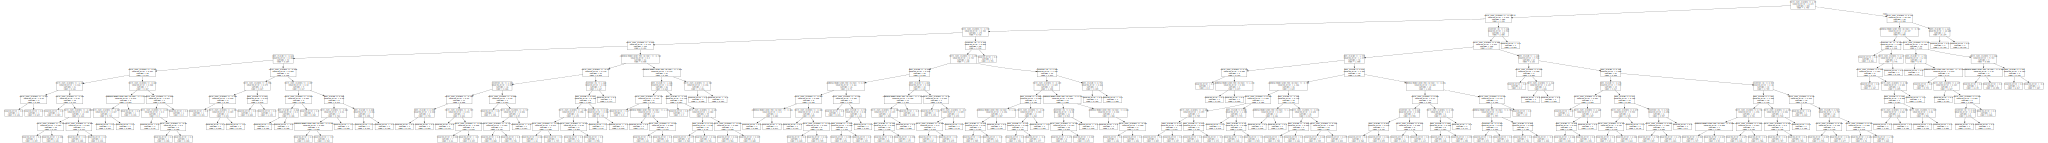

In [31]:
# Generate a plot of the decision tree
graphviz.Source(export_graphviz(ev_model_tree_reg[2], out_file=None, feature_names=features))

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Mean Model'),
  Text(1, 0, 'Decision Tree'),
  Text(2, 0, 'Random Forest'),
  Text(3, 0, 'Extra Random Forest'),
  Text(4, 0, 'Ridge')])

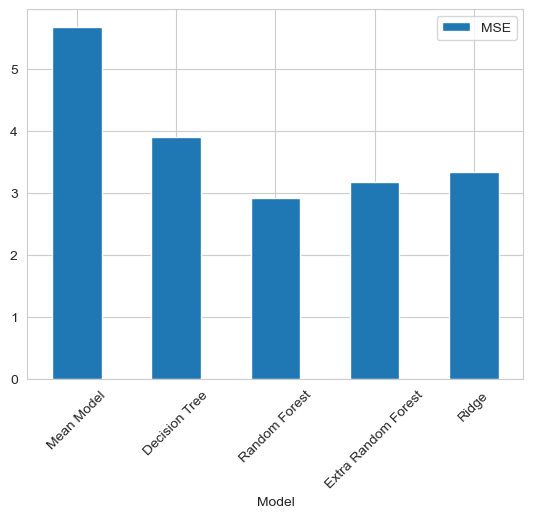

In [32]:
# Decision Tree Regressor and Ensemble Models (Random Forest, Extremely Random Forest)

# Train with default parameters
import pandas as pd
import numpy as np
from sklearn import model_selection, ensemble
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from IPython import display
import graphviz
from sklearn.tree import DecisionTreeClassifier

cv = model_selection.ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
def compute_error(clf, X, y):
    return - model_selection.cross_val_score(clf, X, y, cv=cv, scoring='neg_mean_squared_error').mean()

# Create column transformer 
selector = ColumnTransformer([
    ('numeric', 'passthrough', features)
])

# Create pipelines for ev_models - tree_reg, extra_reg, forest_reg
ev_model_tree_reg= Pipeline([
    ('features', selector),
    ('scaling', StandardScaler()),    
    ('regressor', DecisionTreeRegressor(max_depth=10))
])

ev_model_extra_reg= Pipeline([
    ('features', selector),
    ('scaling', StandardScaler()),    
    ('regressor', ensemble.ExtraTreesRegressor(n_estimators=100))
])

ev_model_forest_reg= Pipeline([
    ('features', selector),
    ('scaling', StandardScaler()),    
    ('regressor', ensemble.RandomForestRegressor(n_estimators=100))
])

model_performance = pd.DataFrame([
    ("Mean Model", np.var(y)),
    ("Decision Tree", compute_error(ev_model_tree_reg, X, y)),
    ("Random Forest", compute_error(ev_model_forest_reg, X, y)),
    ("Extra Random Forest", compute_error(ev_model_extra_reg, X, y)),
    ("Ridge", compute_error(ev_model_ridge, X, y)),
], columns=["Model", "MSE"])
model_performance.plot(x="Model", y="MSE", kind="bar")
plt.xticks(rotation=45)

In [33]:
print(f'Model performance, mean squared error (MSE): \n{model_performance}')

Model performance, mean squared error (MSE): 
                 Model       MSE
0           Mean Model  5.672474
1        Decision Tree  3.903217
2        Random Forest  2.911313
3  Extra Random Forest  3.168885
4                Ridge  3.340747


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Incentive ($)'),
  Text(1, 0, 'Additional Registration Fee ($/year)'),
  Text(2, 0, 'dem_margin'),
  Text(3, 0, 'norm_num_stations')])

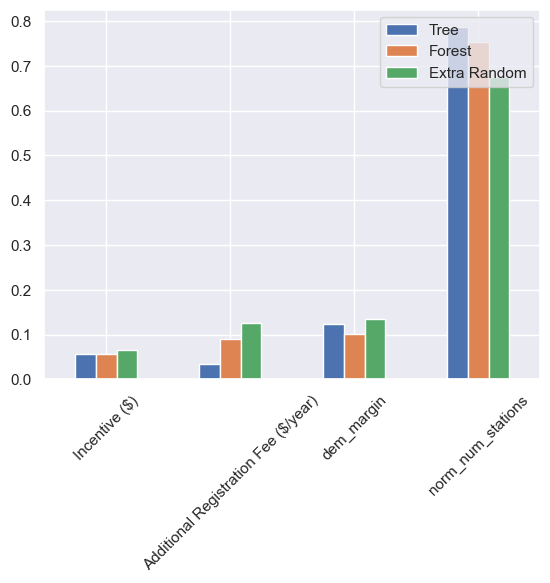

In [34]:
# Determining feature importance
sns.set(font_scale=1)
columns = features
pd.DataFrame([
    ev_model_tree_reg.fit(X, y)[2].feature_importances_,
    ev_model_forest_reg.fit(X, y)[2].feature_importances_,
    ev_model_extra_reg.fit(X, y)[2].feature_importances_,
], columns=columns, index=["Tree", "Forest", "Extra Random"]).T.plot(kind="bar").legend(loc="upper right")
plt.xticks(rotation=45)